<a href="https://colab.research.google.com/github/anubhavsatpathy/EVA/blob/master/Session4/EVA_S4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Network Diagnosis:

This assignment, i believe is focused on helping us diagnose the issues with our neural network so that we can take appropriate measures to improve it's performance and efficiency on any given dataset

###Installing Modules:

In the code below, we install keras and tensorflow libraries to our python environment. The line of code *tf.logging.set_verbosity(tf.logging.ERROR)* does the job of disabling some of the warnings issued by the tensorflow backend



In [1]:
!pip install -q keras
import keras
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)


Using TensorFlow backend.


###Importing Modules:

We utilize the code snippen below to import modules to our runtime so that we can use the interfaces exposed by these modules to write and adjust our CNN. We describe only a few modules below that we have not covered in previous assignments:

- **ModelCheckpoint** : This is among the many callbacks provided by Keras that we can use while training our model. We will use this to store the best model weights so that we do not loose out on them by updations performed during subsequent epochs ([Documentation](https://keras.io/callbacks/))

- **ImageDataGenerator** : This module helps us perform image augmentation which is a very strong regularization measure. We can use this to apply transformations like rotation, translation, random crop etc. on out training dataset before passing them on to the network ([Documentation](https://keras.io/preprocessing/image/))

- **Dropout** : This a keras layer that implements dropouts. Dropouts are another regurarization mechanism that drop certain pixel values while training the model so that our model does not overfit to the training images ([Documentation](https://keras.io/layers/core/))

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from keras.datasets import mnist

from matplotlib import pyplot as plt
%matplotlib inline

###Hyper-Parameters

Each machine learning model will have certain hyper-parameters like batch-size, input shape etc. that are essentially training invariants and are actually agnostic to the model at hand.

To make it easier to iterate with changing these parameters - we usually define them at one place and keep referring to them. This is why we define the dictionary PARAMS in the code below

In [0]:
PARAMS = {
    'INPUT_SHAPE' : (28,28,1),
    'EPOCHS' : 10
}

### Loading and Pre-Processing the Data:

We have been doing these steps for the last two assignments and are now now quite familiar with what these steps do and why are they necessary. Hence - It becomes worthless to inflate our notebook by writing shapes and random images to the console

This is why we wrap all of the data-loading and pre-processing code into a function called load_data() and call this in main() to load the data into our runtime variables *X_train, Y_train, X_test and Y_test*

In [4]:
def load_data():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
  X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_train /= 255
  X_test /= 255
  Y_train = np_utils.to_categorical(y_train, 10)
  Y_test = np_utils.to_categorical(y_test, 10)
  return (X_train, Y_train),(X_test, Y_test)

(X_train, Y_train),(X_test, Y_test) = load_data()

11493376/11490434 [==============================] - 1s 0us/step


### Defining Our First Model:

We were told to start with a vanilla model and so we have taken the model in the first notebook shared during the session as our starting point. 

Salient Features of the Model:

- Over 68K parameters
- 3 Conv Layers
- Huge Kernel Sizes of 26 being used

###What is CKPT?

It is best to think of CKPT as a callback function that checks if the validation accuracy of the current model is better than the best model before this epoch and if so - it stores the weights in a hdf5 file format. 

*P.S : It isnt really a function - it is a class - Please read documentation to know more*

###New signature for model.fit()

- Turns out if we pass validation images and labels to *model.fit()* - it prints out the validation loss and accuracy after every epoch as well

- We pass CKPT in callbacks because after each epoch, we want to see if the best validation accuracy is better than the last best and if so persist the weights

###What to do with the saved weights?

The benefit of saving the weights is that we do not loose them and if someone knows the architecture of our model - he/she can use this file to load our weights into their models and start training / predicting - this is what is used in transfer learning

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 10)        330       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 10)          67610     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 68,260
Trainable params: 68,260
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 36s 598us/step - loss: 0.1979 

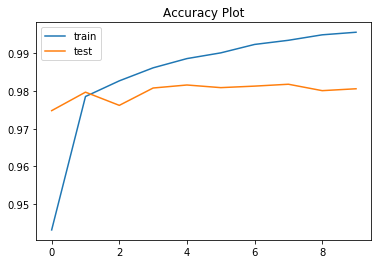

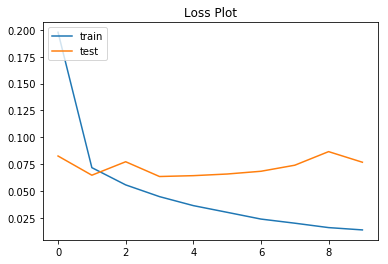

In [5]:
model = Sequential()

# out_shape : [b_s, 26, 26, 32], GRF_of_activations : [3,3]
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=PARAMS['INPUT_SHAPE']))
# out_shape : [b_s, 26, 26, 10], GRF_of_activations : [3,3]
model.add(Convolution2D(10, 1, activation='relu'))
# out_shape : [b_s, 1, 1, 10], GRF_of_activations : [28,28] -- Kernel size of 26 increases GRF by 25 
model.add(Convolution2D(10, 26))
model.add(Flatten())
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_of_first_iteration.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)

H = model.fit(X_train, Y_train, batch_size=32, nb_epoch=PARAMS['EPOCHS'], verbose=1, callbacks = [CKPT], validation_data = (X_test,Y_test))

model.load_weights('best_of_first_iteration.hdf5')
score = model.evaluate(X_test, Y_test, verbose=0)

print("Best Validation Accuracy : {}".format(score[1]*100))

acc_plot = plt.figure(1)
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title("Accuracy Plot")
plt.legend(['train','test'], loc = 'upper left')

loss_plot = plt.figure(2)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Loss Plot")
plt.legend(['train','test'], loc = 'upper left')

plt.show()

    

###Diagnosing our first model:

####Problems with the model

- As can be seen from the plots above - our model started overfitting right after the 1st epoch
- This is evident from the fact that both the validation loss and the validation accuracy start saturating at a plateaue as the training accuracy and loss keep moving in the same direction
- Training Accuracy is 99.56 as well - so there isnt much scope left for improvement at all

####Possible Causes:
The possible causes of this overfitting may be:

- Too many parameters in the network
- A lack of any regularization model
- Large size kernels 

Large size kernels mean more expressive power which means that the model will be able to overfit to the features of the training set that are simply peculiar by coincidence. The example of this is class is the BMW logo behind a frog

####Prescription:
- **Proper Model with less parameters and smaller kernels** : We know how a model should ideally look. We add convolution blocks with increasing number of output channels - then we add a bottlenech layer to collapse to smaller number of channels and then we add convolution blocks again and we repeat this till we acheive a GRF of the image. We do exactly this in the next model

- **Batch Normalization** : Batch normalization is essentially a means of augmenting the input channels to a layer - This prevents a layer from learning peculiar color gradients prevalant in some classes and absent in others due to environmental and photographic conditions. Hence we add BN after ReLU after each convolution layer

###Defining our second model:

A few salient features about our next model:

- About 14K parameters
- All 3x3 kernels for convolution
- Pyramid structures with one bottleneck layer
- Batch Normalization used for all convolution layers
- GRF of 28x28 before flattening our the input

###What are the improvements as per us?

- Batch Normalization after Convolution to reduce pverfitting
- Lesser Parameters and 3x3 kernels for to reduce overfitting

We hope to be able to freeze our architecture moving forward

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), activation="relu")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu")`
/usr/local/lib/python3.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 24)        3480      
_________________________________________________________________
batch_normalization_3 (Batch (None, 22, 22, 24)        96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 24)        0         
__________

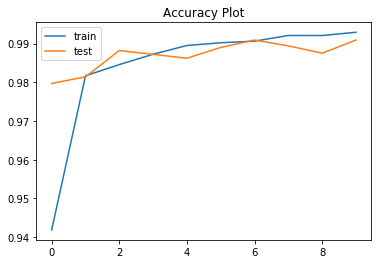

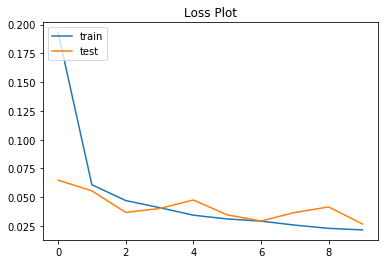

In [6]:
model = Sequential()

# out_shape : [b_s, 26, 26, 8], GRF_of_activations : [3,3]
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=PARAMS['INPUT_SHAPE']))#26
model.add(BatchNormalization())
# out_shape : [b_s, 24, 24, 16], GRF_of_activations : [5,5]
model.add(Convolution2D(16, 3, 3, activation='relu'))#24
model.add(BatchNormalization())
# out_shape : [b_s, 22, 22, 24], GRF_of_activations : [7,7]
model.add(Convolution2D(24,3,3, activation = 'relu'))#22
model.add(BatchNormalization())

# out_shape : [b_s, 11, 11, 24], GRF_of_activations : [8,8]
model.add(MaxPooling2D(2,2))#11
# out_shape : [b_s, 11, 11, 8], GRF_of_activations : [8,8]
model.add(Convolution2D(8, 1, 1, activation = 'relu'))
model.add(BatchNormalization())

# out_shape : [b_s, 9, 9, 8], GRF_of_activations : [12,12]
model.add(Convolution2D(8, 3, 3, activation = 'relu'))#9
model.add(BatchNormalization())
# out_shape : [b_s, 7, 7, 12], GRF_of_activations : [16,16]
model.add(Convolution2D(12, 3, 3, activation = 'relu'))#7
model.add(BatchNormalization())
# out_shape : [b_s, 5, 5, 24], GRF_of_activations : [20,20]
model.add(Convolution2D(24, 3, 3, activation = 'relu'))#5
model.add(BatchNormalization())
# out_shape : [b_s, 3, 3, 16], GRF_of_activations : 24,24]
model.add(Convolution2D(16, 3, 3, activation = 'relu'))#3
model.add(BatchNormalization())
# out_shape : [b_s, 1, 1, 10], GRF_of_activations : 28,28]
model.add(Convolution2D(10, 3, 3, activation = 'relu'))#1

model.add(Flatten())
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_of_second_iteration.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)

H = model.fit(X_train, Y_train, batch_size=32, nb_epoch=PARAMS['EPOCHS'], verbose=1, callbacks = [CKPT], validation_data = (X_test,Y_test))

model.load_weights('best_of_second_iteration.hdf5')
score = model.evaluate(X_test, Y_test, verbose=0)

print("Best Validation Accuracy : {}".format(score[1]*100))

plt.close(acc_plot)
acc_plot = plt.figure(1)
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title("Accuracy Plot")
plt.legend(['train','test'], loc = 'upper left')

plt.close(loss_plot)
loss_plot = plt.figure(2)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Loss Plot")
plt.legend(['train','test'], loc = 'upper left')

plt.show()

###Diagnosing our second model:

####What Improved?

- Overfitting surely improved
- The gap between the scores are now only 0.20 measured in %

####Problems with this network
- Best training accuracy reached was 99.29% only 
- The graphs clearly show overfitting setting in after the second epoch - much slower and smaller than our first model but still enough to reckon with

####Possible Causes
- Lack of stronger regularization measures like Dropouts
- Lack of more training data

####Prescription
- Since we are creating overfitting first - let's add dropout first 
- Learning rate decay
- Image Augmentation

###Defining our third model:

A few salient features about our next model:

- About 14K parameters
- All 3x3 kernels for convolution
- Pyramid structures with one bottleneck layer
- Batch Normalization used for all convolution layers
- GRF of 28x28 before flattening our the input
- Dropout 

###What are the improvements as per us?

- We add dropout after every convolution layer except the last layer - We do this because we are not sure exactly which layer is responsible for this overfitting

We hope to be able to freeze our architecture moving forward


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update y

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_9 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 22, 22, 24)        3480      
__________

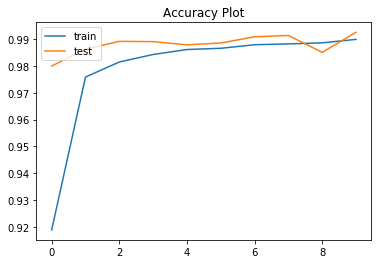

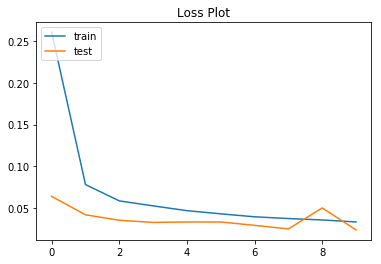

In [7]:
model = Sequential()

#out_shape : [b_s, 26, 26, 8], GRF_of_activations : [3,3]
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=PARAMS['INPUT_SHAPE']))#26
model.add(BatchNormalization())
model.add(Dropout(0.05))

#out_shape : [b_s, 24, 24, 16], GRF_of_activations : [5,5]
model.add(Convolution2D(16, 3, 3, activation='relu'))#24
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 22, 22, 24], GRF_of_activations : [7,7]
model.add(Convolution2D(24,3,3, activation = 'relu'))#22
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 11, 11, 24], GRF_of_activations : [8,8]
model.add(MaxPooling2D(2,2))#11
# out_shape : [b_s, 11, 11, 8], GRF_of_activations : [8,8]
model.add(Convolution2D(8, 1, 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 9, 9, 8], GRF_of_activations : [12,12]
model.add(Convolution2D(8, 3, 3, activation = 'relu'))#9
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 7, 7, 12], GRF_of_activations : [16,16]
model.add(Convolution2D(12, 3, 3, activation = 'relu'))#7
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 5, 5, 24], GRF_of_activations : [20,20]
model.add(Convolution2D(24, 3, 3, activation = 'relu'))#5
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 3, 3, 10], GRF_of_activations : [24,24]
model.add(Convolution2D(16, 3, 3, activation = 'relu'))#3
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 1, 1, 10], GRF_of_activations : [28,28]
model.add(Convolution2D(10, 3, 3, activation = 'relu'))#1

model.add(Flatten())
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_of_third_iteration.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)

H = model.fit(X_train, Y_train, batch_size=32, nb_epoch=PARAMS['EPOCHS'], verbose=1, callbacks = [CKPT], validation_data = (X_test,Y_test))

model.load_weights('best_of_third_iteration.hdf5')
score = model.evaluate(X_test, Y_test, verbose=0)

print("Best Validation Accuracy : {}".format(score[1]*100))

plt.close(acc_plot)
acc_plot = plt.figure(1)
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title("Accuracy Plot")
plt.legend(['train','test'], loc = 'upper left')

plt.close(loss_plot)
loss_plot = plt.figure(2)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Loss Plot")
plt.legend(['train','test'], loc = 'upper left')

plt.show()


###Diagnosing our third model:

####What Improved?

- Overfitting solved - as can be seen - our validation accuracies more or less outperforms out training accuracy
- We got a validation accuracy of 99.26 and a training accuracy of 98.99 - which means there is ample scope of growth
- This raise in validation accuracy is seen since dropouts are used while training and ignored while testing - thus not letting the network overfit the training data

####Problems with this network
- Our training accuracy fell to around 98.9%
- Validation accuracy is still less than 99.4%

####Possible Causes
- Lack of more training data

####Prescription
- Augment the incoming data to create more training data 
- Train using a larger batch size 

###Defining our fourth model:

A few salient features about our next model:

- About 14K parameters
- All 3x3 kernels for convolution
- Pyramid structures with one bottleneck layer
- Batch Normalization used for all convolution layers
- GRF of 28x28 before flattening our the input
- Dropout 
- Data Augmentation

###What are the improvements as per us?

- We randomly rotate, zoom, and shift our images horizontaly and vertically before passing them through the network
- We Increase the batch size to 64 for faster training
- We perform 6000 steps per epoch which means a training size of around 400K

We hope to be able to freeze our architecture moving forward


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 24)        3480      
__________

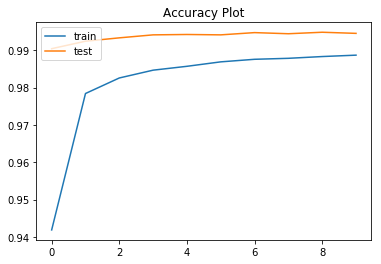

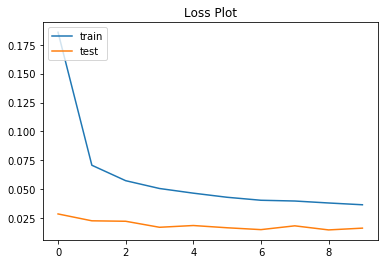

In [6]:
datagen = ImageDataGenerator(rotation_range=10,  
                             zoom_range = 0.10,  
                             width_shift_range=0.1, 
                             height_shift_range=0.1)
data_iter = datagen.flow(X_train,Y_train, batch_size = 64)

model = Sequential()

#out_shape : [b_s, 26, 26, 8], GRF_of_activations : [3,3]
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=PARAMS['INPUT_SHAPE']))#26
model.add(BatchNormalization())
model.add(Dropout(0.05))

#out_shape : [b_s, 24, 24, 16], GRF_of_activations : [5,5]
model.add(Convolution2D(16, 3, 3, activation='relu'))#24
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 22, 22, 24], GRF_of_activations : [7,7]
model.add(Convolution2D(24,3,3, activation = 'relu'))#22
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 11, 11, 24], GRF_of_activations : [8,8]
model.add(MaxPooling2D(2,2))#11
# out_shape : [b_s, 11, 11, 8], GRF_of_activations : [8,8]
model.add(Convolution2D(8, 1, 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 9, 9, 8], GRF_of_activations : [12,12]
model.add(Convolution2D(8, 3, 3, activation = 'relu'))#9
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 7, 7, 12], GRF_of_activations : [16,16]
model.add(Convolution2D(12, 3, 3, activation = 'relu'))#7
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 5, 5, 24], GRF_of_activations : [20,20]
model.add(Convolution2D(24, 3, 3, activation = 'relu'))#5
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 3, 3, 10], GRF_of_activations : [24,24]
model.add(Convolution2D(16, 3, 3, activation = 'relu'))#3
model.add(BatchNormalization())
model.add(Dropout(0.05))

# out_shape : [b_s, 1, 1, 10], GRF_of_activations : [28,28]
model.add(Convolution2D(10, 3, 3, activation = 'relu'))#1

model.add(Flatten())
model.add(Activation('softmax'))


model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_of_fourth_iteration.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)

H = model.fit_generator(data_iter, steps_per_epoch = 6000, epochs = 10, callbacks = [CKPT], validation_data = (X_test,Y_test))
model.load_weights('best_of_fourth_iteration.hdf5')
score = model.evaluate(X_test, Y_test, verbose=0)

print("Best Validation Accuracy : {}".format(score[1]*100))

plt.close(acc_plot)
acc_plot = plt.figure(1)
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title("Accuracy Plot")
plt.legend(['train','test'], loc = 'upper left')

plt.close(loss_plot)
loss_plot = plt.figure(2)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Loss Plot")
plt.legend(['train','test'], loc = 'upper left')

plt.show()

###And Done!!

Thats it! We solved overfitting and we solved the problem of bias. The validation accuracies are cosistently higher than the training accuracies and we reached as high as 99.48% on our vaiidation accuracy!!